# Mise en oeuvre de l'algorithme EM sur les données Galaxy

VALIAU Virgile

DESCARPENTRIES Rémy

### Importations

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import uniform
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_excel("2122_Galaxy.xlsx", header = None)
data = np.array(df).reshape(1,-1)[0]
data

array([ 9172,  9350,  9483,  9558,  9775, 10227, 10406, 16084, 16170,
       18419, 18552, 18600, 18927, 19052, 19070, 19330, 19343, 19349,
       19440, 19473, 19529, 19541, 19547, 19663, 19846, 19856, 19863,
       19914, 19918, 19973, 19989, 20166, 20175, 20179, 20196, 20215,
       20221, 20415, 20629, 20795, 20821, 20846, 20875, 20986, 21137,
       21492, 21701, 21814, 21921, 21960, 22185, 22209, 22242, 22249,
       22314, 22374, 22495, 22746, 22747, 22888, 22914, 23206, 23241,
       23263, 23484, 23538, 23542, 23666, 23706, 23711, 24129, 24285,
       24289, 24366, 24717, 24990, 25633, 26960, 26995, 32065, 32789,
       34279], dtype=int64)

### Histogramme des données

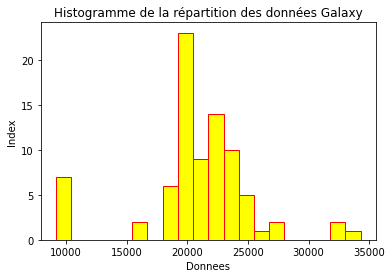

In [3]:
plt.hist(data, bins = 20, density = False, color = 'yellow', edgecolor = "red")
plt.title('Histogramme de la répartition des données Galaxy')
plt.xlabel('Donnees')
plt.ylabel('Index')
plt.show()

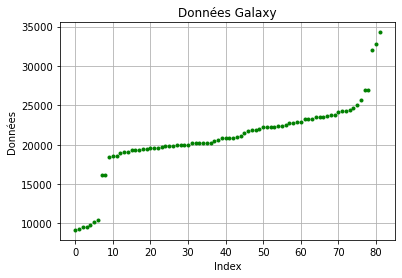

In [4]:
plt.plot(data, 'g.')
plt.title('Données Galaxy')
plt.xlabel('Index')
plt.ylabel('Données')
plt.grid()
plt.show()

### Création de sous-échantillons et calcul des moyennes, écart-types et poids

Au regard de l'histogramme, on modélise dans un premier temps les données Galaxy par quatre gaussiennes.
Ainsi, on crée quatre sous-échantillons, répartis dans quatre listes.

In [5]:
liste1 = []
liste2 = []
liste3 = []
liste4 = []

for i in data : 
    if i<15000:
        liste1.append(i)
    elif i<21200:
        liste2.append(i)
    elif i<30000:
        liste3.append(i)
    else :
        liste4.append(i)
        
l = [liste1, liste2, liste3, liste4]

Pour chaque sous-échantillon, on calcule la moyenne, l'écart-type et le poids.

In [6]:
moy = []
std = []
proba = []
for i in range(len(l)):
    moy.append(np.mean(l[i]))
    std.append(np.std(l[i]))
    proba.append(len(l[i])/len(data))

On modélise à l'aide de l'algorithme EM.

In [7]:
nbMaxIterations = 10
mu_em = np.array(moy)
sigma_em = np.array(std)
alpha_em = np.array(proba)
donnees = data.copy()
nbEchantillon = len(donnees)

nbIteration = 1 #Initialisation de la variable d'arrêt
nbComposante = len(alpha_em) #Nombre de composantes du mélange
nbDonnees = len(donnees)  #Nombre de données
p = np.zeros(shape=(nbComposante, nbDonnees))
#Déclaration et initialisation de la matrice qui va contenir les probabilités
#p(k|x,theta_courant)
                       
alpha_em_new = alpha_em
sigma_em_carre_new = sigma_em
mu_em_new = mu_em
donneesP = np.zeros(shape=(nbEchantillon))

while nbIteration < nbMaxIterations:
    for n in range(0, nbDonnees, 1):
        for k in range(0, nbComposante, 1):
            p[k, n] = alpha_em[k] * norm.pdf(x = donnees[n], loc = mu_em[k], scale = sigma_em[k])
        p[:, n] = p[:, n] / np.sum(p[:, n])
    for k in range(0, nbComposante, 1):
        alpha_em_new[k] = np.sum(p[k,:]) / nbDonnees
        for n in range(0, nbDonnees, 1):
            donneesP[n] = donnees[n] * p[k, n]
        mu_em_new[k]  = np.sum(donneesP) / np.sum(p[k, :])
        for n in range(nbDonnees):
            donneesP[n] = ((donnees[n] - mu_em_new[k]) ** 2) * p[k, n]
        sigma_em_carre_new[k] = np.sum(donneesP) / np.sum(p[k, :])
    mu_em = mu_em_new
    sigma_em = np.sqrt(sigma_em_carre_new)
    alpha_em = alpha_em_new
    nbIteration = nbIteration + 1

In [15]:
print('Les paramètres estimés sont : ')
print('Moyennes des composantes du mélange', mu_em)
print('Ecart type des composantes du mélange', sigma_em)
print('Probabilités des composantes du mélange', alpha_em)

Les paramètres estimés sont : 
Moyennes des composantes du mélange [ 9710.14285713 19903.50359364 23124.79656533 33044.33529187]
Ecart type des composantes du mélange [ 422.51066886 1349.41494601 1671.69759824  921.71765793]
Probabilités des composantes du mélange [0.08536585 0.46909393 0.40895493 0.03658529]


In [9]:
print('La somme des probabilités des composantes du mélange vaut : ', np.sum(alpha_em))

La somme des probabilités des composantes du mélange vaut :  1.0


In [10]:
def gm_pdf(x, mu, sigma, p):
    #Initialisation de la variable de sortie
    resultat = 0.0
    #Contrôle de la cohérence des paramètres d'entrée
    #Le vecteur de moyenne doit avoir la même longueur que le vecteur p
    if len(mu) != len(p):
        print('Erreur de dimension sur la moyenne')
    # Le vecteur des écart-types doit avoir la même longueur que le vecteur p
    elif len(sigma) != len(p):
            print('Erreur de dimension sur les écarts-types')
    else:
    # Calcul de la valeur de la densité
        for i in range(0, len(p)):
            resultat = resultat + p[i] * norm.pdf(x, mu[i], sigma[i])
    return resultat

Puis, on trace la densité de probabilité originale et celle calculée à partir de l'algorithme EM.

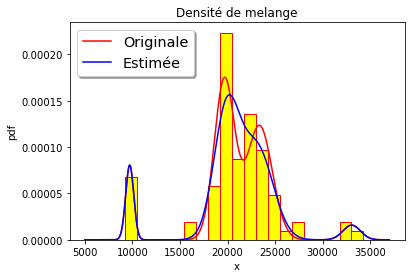

In [11]:
x = np.arange(5000,37000, 0.01)
pointPdf = gm_pdf(x, moy, std, proba)

plt.plot(x, pointPdf, 'r-', label = 'Originale')
plt.title('Densité de mélange')
plt.xlabel('x')
plt.ylabel('pdf')
pointPdfEstime = gm_pdf(x, mu_em, sigma_em, alpha_em)
plt.plot(x, pointPdfEstime, 'b-', label = 'Estimée')
plt.hist(data, bins = 20, density = True, color = 'yellow', edgecolor = "red")
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()

On obtient ainsi une densité de probabilité "estimée" assez proche de la densité originale, bien que deux gaussiennes semblent se confondre l'une avec l'autre pour ne former qu'une seule gaussienne. 

### Modélisation avec Gaussian Mixture de Sklearn

On modélise les données pour un nombre de gaussiennes variant de 1 à 8.

Nombre de gaussiennes = 1


C:\Users\remyd\anaconda3new\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


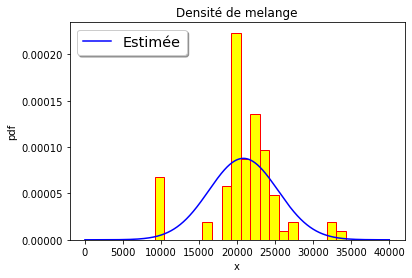

Nombre de gaussiennes = 2


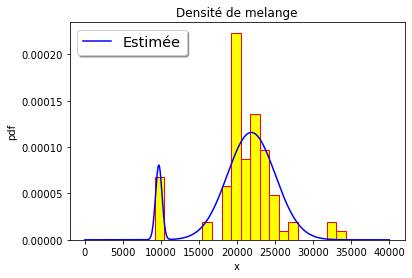

Nombre de gaussiennes = 3


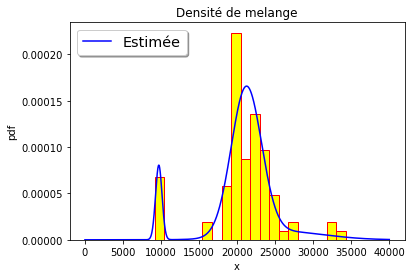

Nombre de gaussiennes = 4


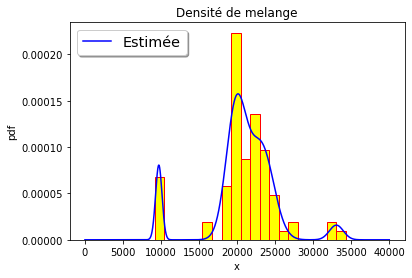

Nombre de gaussiennes = 5


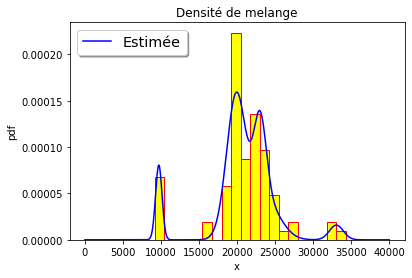

Nombre de gaussiennes = 6


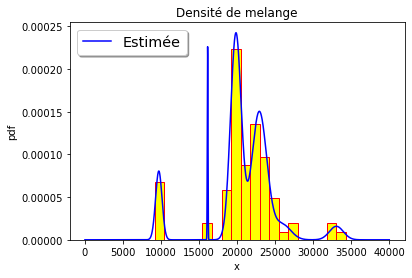

Nombre de gaussiennes = 7


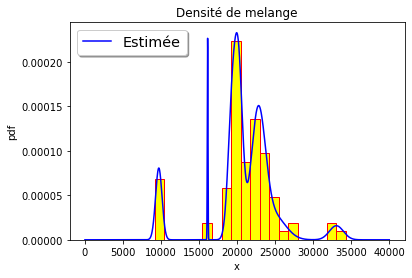

Nombre de gaussiennes = 8


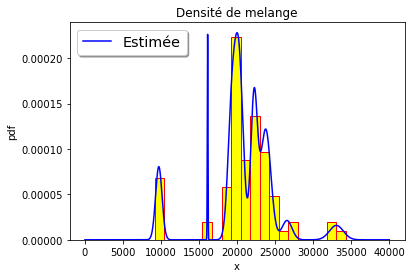

In [12]:
import numpy as np
from sklearn import mixture
from sklearn.mixture import GaussianMixture
X = data.copy()

for n in range(1,9):
    print ('Nombre de gaussiennes =', n)
    gmm = mixture.GaussianMixture(n_components=n)
    gmm.fit(X.reshape(-1,1))
    weights = gmm.weights_
    means = gmm.means_
    covariances = gmm.covariances_

    x = np.arange(0,40000, 0.01)

    plt.title('Densité de melange')
    plt.xlabel('x')
    plt.ylabel('pdf')
    pointPdfEstime = gm_pdf(x, [means[i][0] for i in range(len(means))], [np.sqrt(covariances[i][0][0]) for i in range (len(covariances))], weights)
    plt.plot(x, pointPdfEstime, 'b-', label = 'Estimée')
    plt.hist(data, bins = 20, density = True, color = 'yellow', edgecolor = "red")
    plt.legend(loc='upper left', shadow=True, fontsize='x-large')
    plt.show()

Si on choisit un nombre de gaussiennes trop important, on obtient des pics correspondant à un sous-échantillon comportant un faible nombre de données. Au contraire, si le nombre de gaussiennes est trop faible, le modèle ne tient pas compte des données isolées. L'objectif est donc de choisir le bon nombre de gaussiennes pour coller le plus possible à l'échantillon des données. Dans notre problème, le bon compromis peut être trouvé pour 4 ou 5 gaussiennes.

Par ailleurs, on remarque que notre première modélisation avec l'algorithme EM pour 4 gaussiennes est très proche de la modélisation proposée par sklearn pour le même nombre de gaussiennes.

La méthode sklearn présente un inconvénient qui réside dans son caractère aléatoire. Ainsi, il est possible qu'elle ne propose pas la même modélisation d'une exécution à une autre, avec les mêmes paramètres.